In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.stattools import grangercausalitytests

from src.featureextraction import low_pass_filter, kalman_filter, median_filter, run

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_df = pd.read_csv('C:\\Users\\hagan\\OneDrive\\Uni Work\\CE888 Data Science and Decision Making\\datasets\\merged_data_labeled.csv')
split_columns = main_df['datetime'].str.split(' ', expand=True)
main_df['date'] = split_columns[0]
main_df['time'] = main_df['datetime']
main_df.drop('datetime', axis=1, inplace=True)
main_df = main_df[['X', 'Y', 'Z', 'EDA', 'HR', 'TEMP', 'BVP', 'TI', 'IBI', 'id', 'date', 'time', 'label']]
main_df['id'] = main_df['id'].astype(str)
main_df['date'] = pd.to_datetime(main_df['date'])
main_df['time'] = pd.to_datetime(main_df['time'])
main_df

,X,Y,Z,EDA,HR,TEMP,BVP,TI,IBI,id,date,time,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,-1242.45,103.140625,0.687500,15,2020-07-08,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,-1321.94,103.140625,0.687500,15,2020-07-08,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,-1317.50,103.140625,0.687500,15,2020-07-08,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,-1397.41,103.140625,0.687500,15,2020-07-08,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,-1628.31,103.140625,0.687500,15,2020-07-08,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23019347,-47.0,-8.0,43.0,0.121668,98.70,31.19,-47.19,200.921875,0.484375,F5,2020-07-23,2020-07-23 17:28:59.859375104,2.0
23019348,-47.0,-8.0,43.0,0.121668,98.70,31.19,-82.85,200.921875,0.484375,F5,2020-07-23,2020-07-23 17:28:59.890625024,2.0
23019349,-47.0,-8.0,43.0,0.121668,98.70,31.19,-94.94,200.921875,0.484375,F5,2020-07-23,2020-07-23 17:28:59.921874944,2.0
23019350,-47.0,-8.0,43.0,0.121668,98.70,31.19,-88.63,200.921875,0.484375,F5,2020-07-23,2020-07-23 17:28:59.953125120,2.0


# Denoising 
In order to denoise the raw time-series data, various filters were applied to each feature.

| Feature | Filter                               |
|---------|--------------------------------------|
| X       | Butterworth Filter and Kalman Filter |
| Y       | Butterworth Filter and Kalman Filter |
| Z       | Butterworth Filter and Kalman Filter |
| EDA     | Medium Filter                        |
| HR      | N/A                                  |
| TEMP    | Butterworth Filter and Kalman Filter |
| BVP     | Butterworth Filter and Kalman Filter |

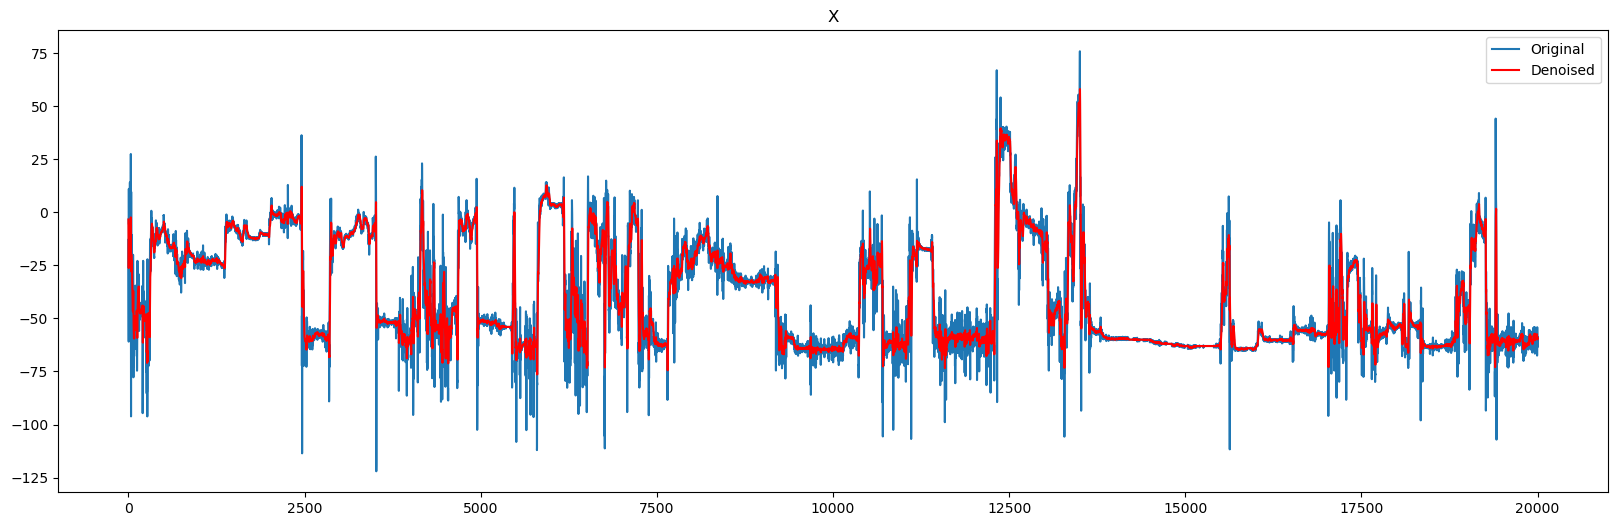

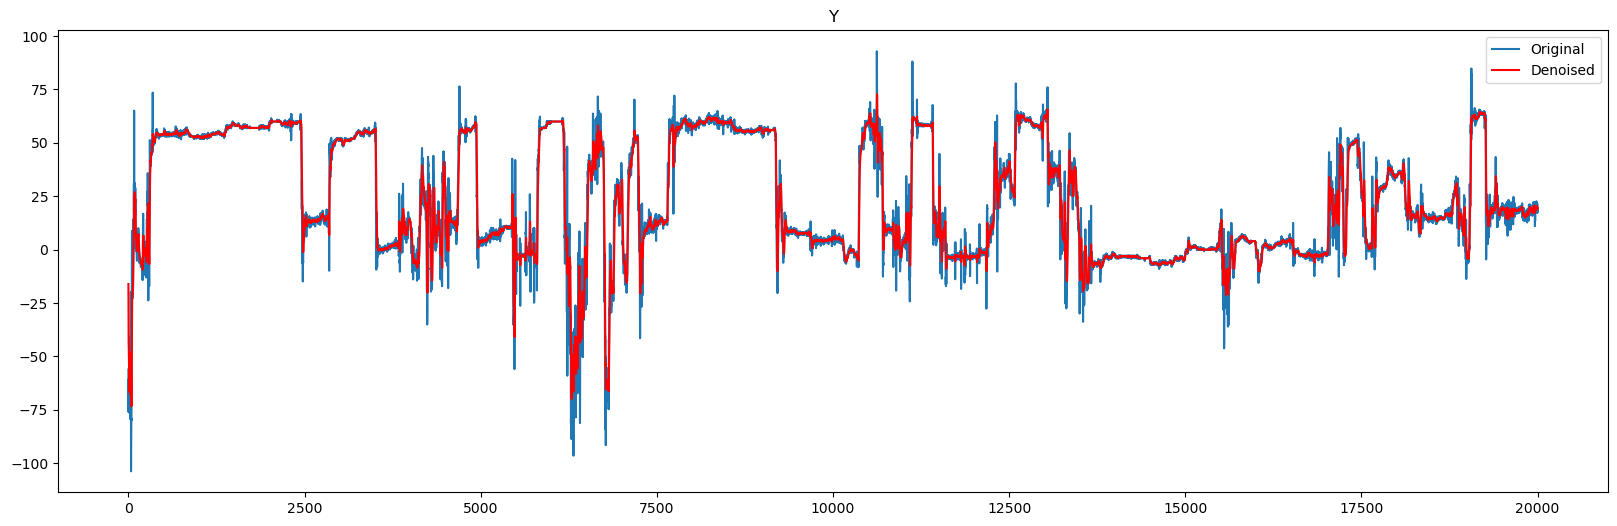

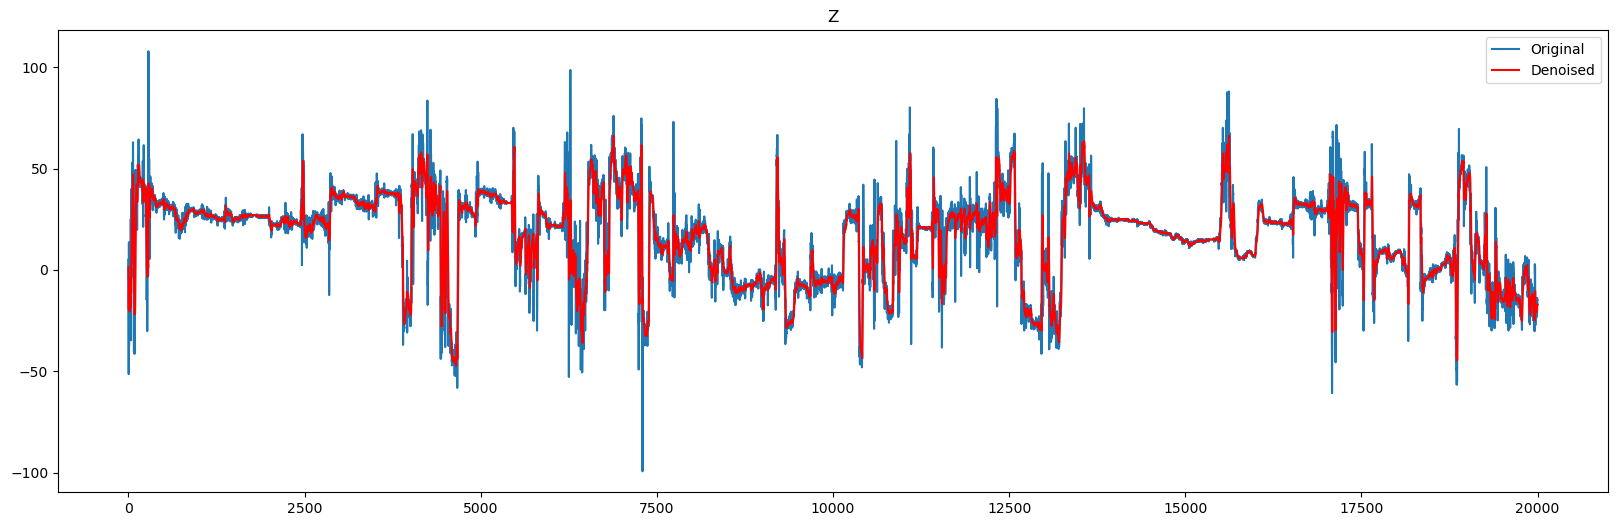

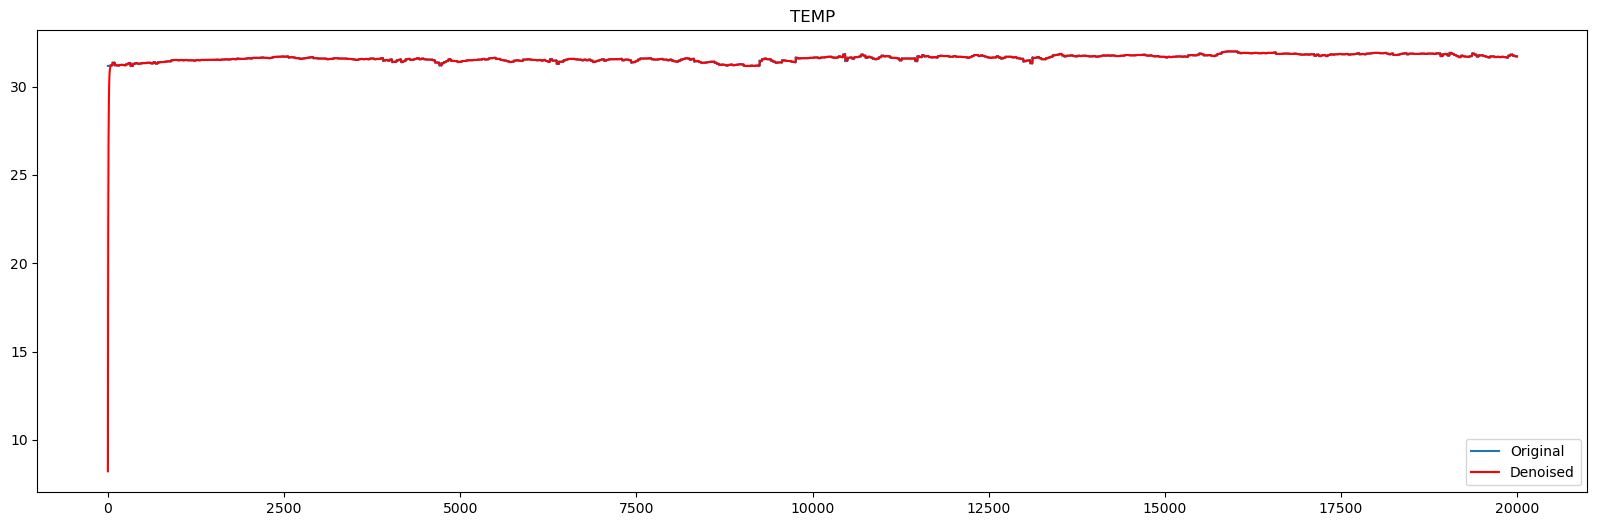

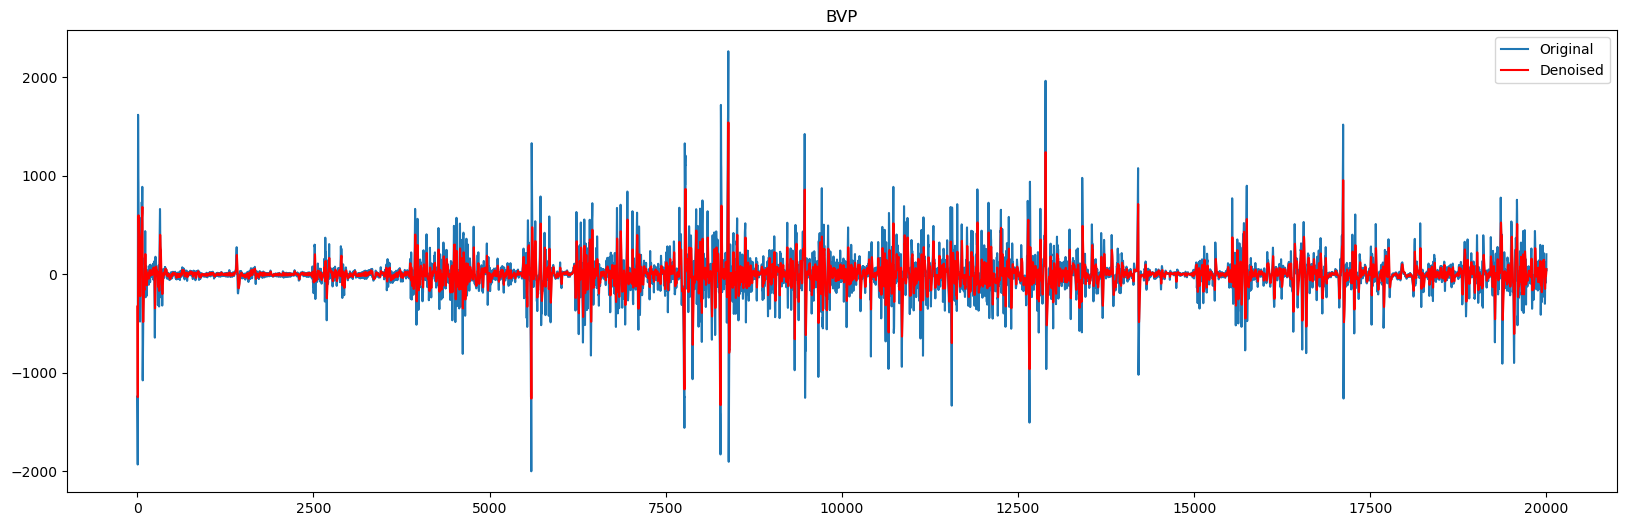

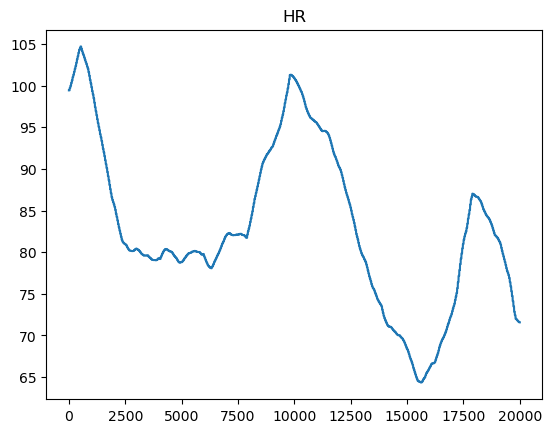

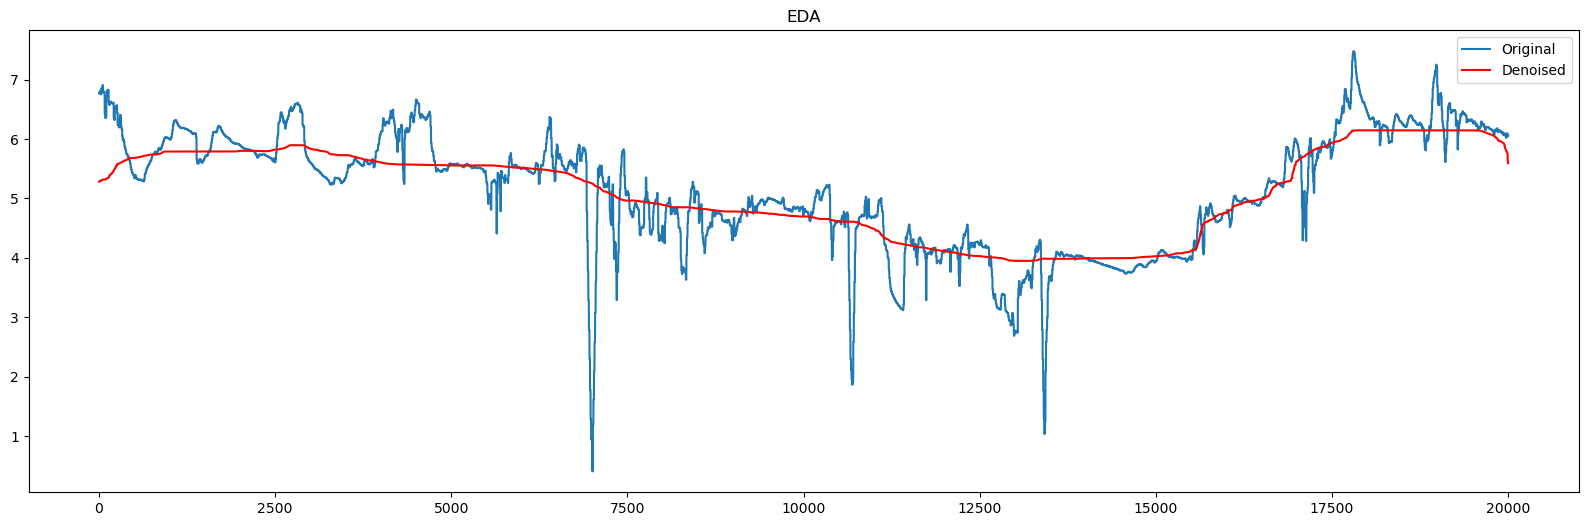

In [ ]:
desired = ['X', 'Y', 'Z', 'TEMP', 'BVP']
filter_df = main_df.head(20000)
for x in desired:
    title = x
    x = filter_df[x].values
    x = low_pass_filter(x, 1.5, 4.0)
    denoised = kalman_filter(x, process_noise=0.0075, measurement_noise=0.3)
    plt.figure(figsize=(20,6))
    plt.plot(x)
    plt.plot(denoised, 'r')
    plt.legend(('Original', 'Denoised'), loc='best')
    plt.title(title)
    plt.show()


desired = ['HR']
for x in desired:
    title = x
    x = filter_df[x].values
    plt.title(title)
    plt.plot(x)
    plt.show()


desired = ['EDA']
for x in desired:
    title = x
    x = filter_df[x].values
    denoised = median_filter(low_pass_filter(x, 1.5, 4.0), 4001)
    plt.figure(figsize=(20,6))
    plt.plot(x)
    plt.plot(denoised, 'r')
    plt.legend(('Original', 'Denoised'), loc='best')
    plt.title(x)
    plt.title(title)
    plt.show()


# Lag Feature Testing

In order to extract the most amount of features, lag features are utilised. In order to establish what lag features to use, a combination of the Granger Causality Test and the Partial Autocorrection Function are used.

In [ ]:
def granger_causality_test(df, test_cols, p_value_threshold, lag_seconds):
    results = {}
    for t in test_cols:
        x1 = df[t]
        x2 = df['label']
        combined_data = pd.DataFrame({'x': x1.values, 'y': x2.values})
        pair_key = f'{t} -> label'

        print(pair_key)
        test_result = grangercausalitytests(combined_data, lag_seconds, verbose=True)
        significant_lags = [lag for lag, result in test_result.items() if result[0]['ssr_ftest'][1] < p_value_threshold]

        if significant_lags:
            results[pair_key] = significant_lags

    return results

test_df = pd.read_csv('C:\\Users\\hagan\\OneDrive\\Uni Work\\CE888 Data Science and Decision Making\\datasets\\cleaned\\5C_cleaned.csv')

test = ['HR', 'TEMP', 'EDA']
lag_seconds = np.array([1, 2, 5, 10]) * 4
p_value_threshold = 0.05

significant_lags = granger_causality_test(test_df, test, p_value_threshold, lag_seconds)

print("Significant lags for Granger causality:")
for pair, lags in significant_lags.items():
    print(f"{pair}: {np.array(lags) / 4}")


HR -> label

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1579  , p=0.9595  , df_denom=1731837, df_num=4
ssr based chi2 test:   chi2=0.6315  , p=0.9595  , df=4
likelihood ratio test: chi2=0.6315  , p=0.9595  , df=4
parameter F test:         F=0.1579  , p=0.9595  , df_denom=1731837, df_num=4

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.0789  , p=0.9997  , df_denom=1731825, df_num=8
ssr based chi2 test:   chi2=0.6316  , p=0.9997  , df=8
likelihood ratio test: chi2=0.6316  , p=0.9997  , df=8
parameter F test:         F=0.0789  , p=0.9997  , df_denom=1731825, df_num=8

Granger Causality
number of lags (no zero) 20
ssr based F test:         F=0.0316  , p=1.0000  , df_denom=1731789, df_num=20
ssr based chi2 test:   chi2=0.6318  , p=1.0000  , df=20
likelihood ratio test: chi2=0.6318  , p=1.0000  , df=20
parameter F test:         F=0.0316  , p=1.0000  , df_denom=1731789, df_num=20

Granger Causality
number of lags (no zero) 40
ssr ba

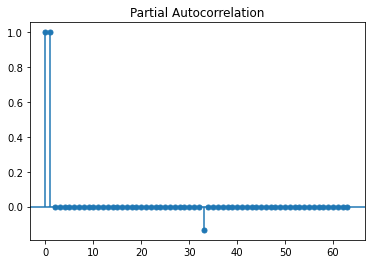

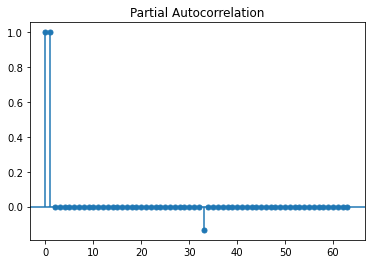

In [ ]:
plot_pacf(test_df['HR'])

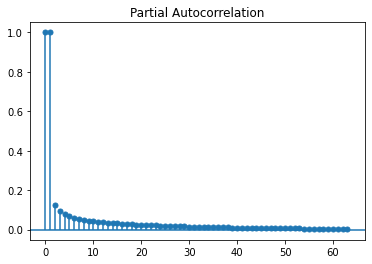

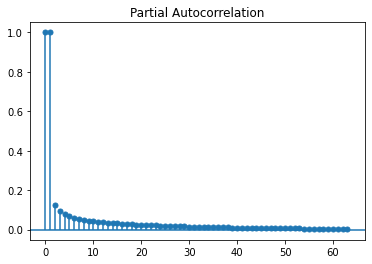

In [ ]:
plot_pacf(test_df['TEMP'])

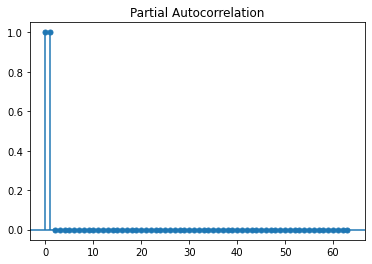

In [ ]:
fig, ax = plt.subplots()
plot_pacf(test_df['EDA'], ax=ax)
fig.savefig('EDA_pacf_plot.png')
plt.show()

# Feature Extraction

In order to complete the feature extraction, the raw time-series data is windowed, with the lag features being lagged before windowing. Each window has a size of 5, leading to a window length of 1.25 seconds as the raw data is sampled at 4Hz. The mean, std, min, max and dx are extracted per window.

Erroneous data is also removed before extraction. Flat lines (areas where the sensors are not picking up data) are detected and removed.

The pipeline for feature extraction is as followed:
input raw data -> remove erroneous data -> denoise -> lag features -> window data -> extract features

In [ ]:
run() # Will perform feature extract

# Testing relationship between features and label 
Testing to see if there is enough difference in the label using T2 Test and MANOVA Tests.

In [ ]:
!pip install hotelling

In [ ]:
from hotelling.stats import hotelling_t2
from statsmodels.multivariate.manova import MANOVA

In [ ]:
df = pd.read_csv('data/cleaned/combined_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])
df = df.drop(['id', 'time', 'date'], axis=1)

pairs = (0, 1), (0, 2), (1, 2)

for pair in pairs:
    label1_data = df[df['label'] == pair[0]]
    label2_data = df[df['label'] == pair[1]]

    label1_data = label1_data.drop(['label'], axis=1)
    label2_data = label2_data.drop(['label'], axis=1)

    t_score, f_value, p_value, _ = hotelling_t2(label1_data, label2_data)

    print(f'Hotelling T2 Test: label {pair[0]} vs label {pair[1]}')
    if p_value < 0.05:
        print(f"p_value: {p_value}. There is a significant difference between the two specific labels.")
    else:
        print(f"p_value: {p_value}. There is no significant difference between the two specific labels.")
    print("\n")

Hotelling T2 Test: label 0 vs label 1
p_value: 0.0. There is a significant difference between the two specific labels.


Hotelling T2 Test: label 0 vs label 2
p_value: 0.0. There is a significant difference between the two specific labels.


Hotelling T2 Test: label 1 vs label 2
p_value: 0.0. There is a significant difference between the two specific labels.




In [ ]:
features = [x for x in df.columns if x not in ['label']]
formula = " + ".join(features) + " ~ label"
manova = MANOVA.from_formula(formula, data=df)
result = manova.mv_test()
print(result)

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept         Value   Num DF    Den DF     F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda -0.5407 48.0000 887243.0000 -52671.7159 1.0000
         Pillai's trace 27.5538 48.0000 887243.0000 -19180.3345 1.0000
 Hotelling-Lawley trace 44.6788 48.0000 887243.0000 825853.0868 0.0000
    Roy's greatest root 45.7056 48.0000 887243.0000 844833.0592 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
            label          Value   Num DF    Den DF    F Value  Pr > F
----------------------------------------------------------------------
             Wilks' lambda 0.

# Feature Extraction
Recursive Feature Extraction (RFE) is used to extract the most relevent features for each individual. 

The most prevalent selection is: 

['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_min', 'HR_max',
       'TEMP_max', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min', 'lag_EDA_max',
       'lag_HR_mean', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']


In [ ]:
df = df.read_csv()
df = df.drop(['X_mean', 'X_std', 'X_dx', 'Y_mean', 'Y_std', 'Y_dx', 'Z_mean', 'Z_std', 'Z_dx', 'X_min', 'X_max', 'Y_min', 'Y_max', 'Z_min', 'Z_max'], axis=1)
cols = transformed_df.columns
features = [col for col in df.columns if col not in ['id', 'date', 'time', 'label']]

colTransformer = ColumnTransformer([('num', StandardScaler(), features)],remainder='passthrough')
df = colTransformer.fit_transform(df)
df = pd.DataFrame(df, columns=cols)
df['label'] = to_categorical(df['label'], num_classes=3)


for p in df['id'].unique():
  X = df[df['id'].isin([p])]
  try:
    X_train, X_test, y_train, y_test = train_test_split(X[features], to_categorical(X['label'], num_classes=3), test_size=0.2, random_state=42)
  except:
    print(p)
    print(X)
    break

  clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
  rfe = RFE(clf, verbose=0)
  X_rfe = rfe.fit_transform(X_train, y_train)
  temp = pd.Series(rfe.support_, index=features)
  print(f'{p}: {temp[temp==True].index}')


5C: Index(['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_min', 'HR_max',
       'TEMP_max', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min', 'lag_EDA_max',
       'lag_HR_mean', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max'],
      dtype='object')
6B: Index(['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'TEMP_mean', 'TEMP_min',
       'TEMP_max', 'BVP_mean', 'BVP_min', 'BVP_max', 'lag_EDA_mean',
       'lag_EDA_min', 'lag_EDA_max', 'lag_HR_min', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max'],
      dtype='object')
6D: Index(['EDA_mean', 'EDA_min', 'EDA_max', 'HR_max', 'TEMP_mean', 'TEMP_min',
       'TEMP_max', 'BVP_mean', 'BVP_min', 'BVP_max', 'lag_EDA_mean',
       'lag_EDA_min', 'lag_EDA_max', 'lag_HR_mean', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max'],
      dtype='object')
7A: Index(['EDA_mean', 'EDA_min', 'EDA_max', 'HR_min', 'TEMP_mean', 'TEMP_min',
       'TEMP_max', 'BVP_mean', 'BVP_min', 'BVP_max', 'lag_EDA_mean',
       'la

# Model Generation and Evaluation
A model is generated for each individual and tested using 5 Fold Cross Validation.

In [ ]:
def evaluate(model, X, y, cv):
  keras_eval = KerasClassifier(model=model, optimizer='adam', epochs=100, verbose=0)
  scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='weighted'),
           'recall' : make_scorer(recall_score, average="weighted"), 
           'f1_score' : make_scorer(f1_score, average="weighted")}
  return cross_validate(estimator=keras_eval, X=X, y=y, cv=cv, scoring=scoring, error_score="raise")

def plot_results(title, results):
  mean_acc = np.mean(results['test_accuracy'])
  mean_prec = np.mean(results['test_precision'])
  mean_rec = np.mean(results['test_recall'])
  mean_f1 = np.mean(results['test_f1_score'])

  results['mean_accuracy'] = mean_acc
  results['mean_precision'] = mean_prec
  results['mean_recall'] = mean_rec
  results['mean_f1'] = mean_f1

  save_loc = f'/content/drive/MyDrive/CE888/jsons/{title} Model Score'
  results = {key: value.tolist() for key, value in results.items()}
  with open(save_loc, 'w') as json_file:
    json.dump(results, json_file, indent=4)

  labels = ['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1']
  values = [mean_acc, mean_prec, mean_rec, mean_f1]
  plt.bar(labels, values)

  plt.ylim(0, 1)
  plt.xlabel('Model')
  plt.ylabel('Scores')
  plt.title(f'{title} Model Scores')

  save_loc = f'/content/drive/MyDrive/CE888/scorefigs/{title} Model Score'
  plt.savefig(save_loc, bbox_inches='tight')
  plt.show()


## Combined

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/combined_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelcombined = MakeModel(df, cols)
modelcombined.fit_model()

Epoch 1/80
11092/11092 - 88s - loss: 0.6097 - accuracy: 0.7551 - val_loss: 0.5683 - val_accuracy: 0.7666 - 88s/epoch - 8ms/step
Epoch 2/80
11092/11092 - 75s - loss: 0.5299 - accuracy: 0.7850 - val_loss: 0.5104 - val_accuracy: 0.7910 - 75s/epoch - 7ms/step
Epoch 3/80
11092/11092 - 74s - loss: 0.5026 - accuracy: 0.7935 - val_loss: 0.4922 - val_accuracy: 0.7964 - 74s/epoch - 7ms/step
Epoch 4/80
11092/11092 - 81s - loss: 0.4823 - accuracy: 0.7999 - val_loss: 0.4901 - val_accuracy: 0.7990 - 81s/epoch - 7ms/step
Epoch 5/80
11092/11092 - 77s - loss: 0.4654 - accuracy: 0.8065 - val_loss: 0.4581 - val_accuracy: 0.8093 - 77s/epoch - 7ms/step
Epoch 6/80
11092/11092 - 76s - loss: 0.4518 - accuracy: 0.8113 - val_loss: 0.4430 - val_accuracy: 0.8154 - 76s/epoch - 7ms/step
Epoch 7/80
11092/11092 - 76s - loss: 0.4394 - accuracy: 0.8155 - val_loss: 0.4378 - val_accuracy: 0.8158 - 76s/epoch - 7ms/step
Epoch 8/80
11092/11092 - 77s - loss: 0.4296 - accuracy: 0.8189 - val_loss: 0.4273 - val_accuracy: 0.8190

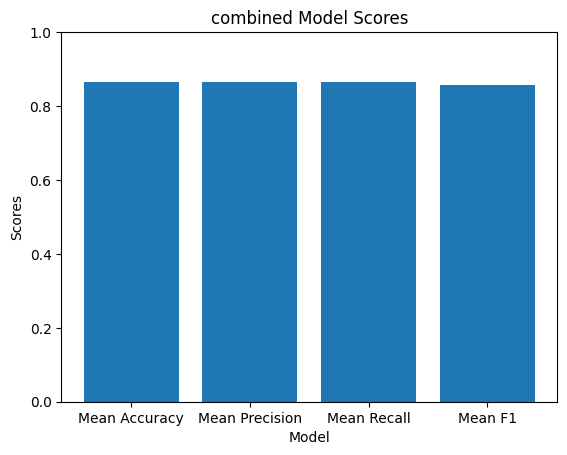

In [ ]:
model = modelcombined.get_model()
X_train, _, y_train, _ = modelcombined.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('combined', results)

## 83

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/83_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model83 = MakeModel(df, cols)
model83.fit_model()

Epoch 1/80
1716/1716 - 24s - loss: 0.3187 - accuracy: 0.8950 - val_loss: 0.2963 - val_accuracy: 0.8986 - 24s/epoch - 14ms/step
Epoch 2/80
1716/1716 - 12s - loss: 0.2885 - accuracy: 0.9017 - val_loss: 0.3105 - val_accuracy: 0.8883 - 12s/epoch - 7ms/step
Epoch 3/80
1716/1716 - 12s - loss: 0.2789 - accuracy: 0.9032 - val_loss: 0.2756 - val_accuracy: 0.9033 - 12s/epoch - 7ms/step
Epoch 4/80
1716/1716 - 11s - loss: 0.2689 - accuracy: 0.9056 - val_loss: 0.2670 - val_accuracy: 0.9059 - 11s/epoch - 6ms/step
Epoch 5/80
1716/1716 - 11s - loss: 0.2631 - accuracy: 0.9075 - val_loss: 0.2659 - val_accuracy: 0.9041 - 11s/epoch - 6ms/step
Epoch 6/80
1716/1716 - 11s - loss: 0.2590 - accuracy: 0.9093 - val_loss: 0.2751 - val_accuracy: 0.9033 - 11s/epoch - 7ms/step
Epoch 7/80
1716/1716 - 11s - loss: 0.2546 - accuracy: 0.9105 - val_loss: 0.2522 - val_accuracy: 0.9126 - 11s/epoch - 7ms/step
Epoch 8/80
1716/1716 - 11s - loss: 0.2520 - accuracy: 0.9114 - val_loss: 0.2489 - val_accuracy: 0.9134 - 11s/epoch - 

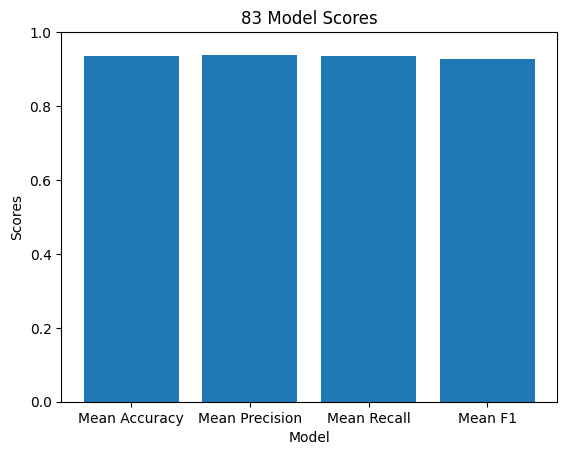

In [ ]:
model = model83.get_model()
X_train, _, y_train, _ = model83.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('83', results)

## DF 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/DF_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])
df['label'] = df['label'].replace(1, 0)
df['label'] = df['label'].replace(2, 1)

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelDF = MakeModel(df, cols)
modelDF.fit_model()

Epoch 1/80
1135/1135 - 23s - loss: 0.2335 - accuracy: 0.9281 - val_loss: 0.2145 - val_accuracy: 0.9281 - 23s/epoch - 20ms/step
Epoch 2/80
1135/1135 - 12s - loss: 0.2098 - accuracy: 0.9290 - val_loss: 0.2088 - val_accuracy: 0.9312 - 12s/epoch - 10ms/step
Epoch 3/80
1135/1135 - 11s - loss: 0.1970 - accuracy: 0.9326 - val_loss: 0.1876 - val_accuracy: 0.9361 - 11s/epoch - 10ms/step
Epoch 4/80
1135/1135 - 12s - loss: 0.1763 - accuracy: 0.9448 - val_loss: 0.1690 - val_accuracy: 0.9508 - 12s/epoch - 11ms/step
Epoch 5/80
1135/1135 - 12s - loss: 0.1674 - accuracy: 0.9496 - val_loss: 0.1650 - val_accuracy: 0.9521 - 12s/epoch - 11ms/step
Epoch 6/80
1135/1135 - 10s - loss: 0.1640 - accuracy: 0.9511 - val_loss: 0.1616 - val_accuracy: 0.9515 - 10s/epoch - 9ms/step
Epoch 7/80
1135/1135 - 12s - loss: 0.1620 - accuracy: 0.9515 - val_loss: 0.1603 - val_accuracy: 0.9515 - 12s/epoch - 10ms/step
Epoch 8/80
1135/1135 - 15s - loss: 0.1594 - accuracy: 0.9525 - val_loss: 0.1596 - val_accuracy: 0.9527 - 15s/epo

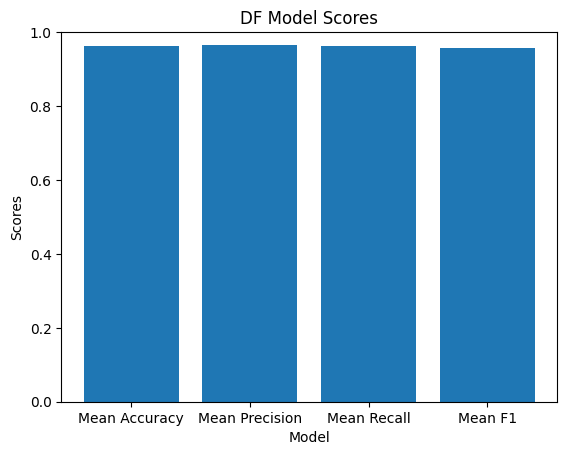

In [ ]:
model = modelDF.get_model()
X_train, _, y_train, _ = modelDF.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('DF', results)

## F5

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/F5_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelF5 = MakeModel(df, cols)
modelF5.fit_model()

Epoch 1/80
669/669 - 27s - loss: 0.1568 - accuracy: 0.9638 - val_loss: 0.1085 - val_accuracy: 0.9723 - 27s/epoch - 40ms/step
Epoch 2/80
669/669 - 6s - loss: 0.1201 - accuracy: 0.9678 - val_loss: 0.1075 - val_accuracy: 0.9708 - 6s/epoch - 8ms/step
Epoch 3/80
669/669 - 5s - loss: 0.1172 - accuracy: 0.9688 - val_loss: 0.1079 - val_accuracy: 0.9720 - 5s/epoch - 7ms/step
Epoch 4/80
669/669 - 6s - loss: 0.1166 - accuracy: 0.9693 - val_loss: 0.1052 - val_accuracy: 0.9729 - 6s/epoch - 10ms/step
Epoch 5/80
669/669 - 5s - loss: 0.1159 - accuracy: 0.9695 - val_loss: 0.1053 - val_accuracy: 0.9729 - 5s/epoch - 7ms/step
Epoch 6/80
669/669 - 5s - loss: 0.1158 - accuracy: 0.9694 - val_loss: 0.1090 - val_accuracy: 0.9711 - 5s/epoch - 7ms/step
Epoch 7/80
669/669 - 6s - loss: 0.1154 - accuracy: 0.9695 - val_loss: 0.1048 - val_accuracy: 0.9733 - 6s/epoch - 10ms/step
Epoch 8/80
669/669 - 5s - loss: 0.1152 - accuracy: 0.9697 - val_loss: 0.1051 - val_accuracy: 0.9729 - 5s/epoch - 8ms/step
Epoch 9/80
669/669 

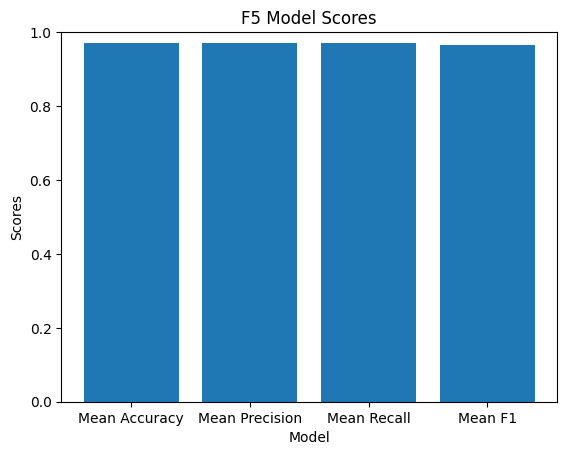

In [ ]:
model = modelF5.get_model()
X_train, _, y_train, _ = modelF5.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('F5', results)

## CE

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/CE_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

df['label'] = df['label'].replace(1, 0)
df['label'] = df['label'].replace(2, 1)


cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelCE = MakeModel(df, cols)
modelCE.fit_model()

Epoch 1/80
1018/1018 - 17s - loss: 0.0864 - accuracy: 0.9852 - val_loss: 0.0566 - val_accuracy: 0.9882 - 17s/epoch - 16ms/step
Epoch 2/80
1018/1018 - 8s - loss: 0.0576 - accuracy: 0.9879 - val_loss: 0.0545 - val_accuracy: 0.9889 - 8s/epoch - 8ms/step
Epoch 3/80
1018/1018 - 8s - loss: 0.0571 - accuracy: 0.9880 - val_loss: 0.0541 - val_accuracy: 0.9889 - 8s/epoch - 7ms/step
Epoch 4/80
1018/1018 - 9s - loss: 0.0571 - accuracy: 0.9880 - val_loss: 0.0532 - val_accuracy: 0.9889 - 9s/epoch - 9ms/step
Epoch 5/80
1018/1018 - 7s - loss: 0.0573 - accuracy: 0.9879 - val_loss: 0.0535 - val_accuracy: 0.9889 - 7s/epoch - 7ms/step
Epoch 6/80
1018/1018 - 8s - loss: 0.0570 - accuracy: 0.9880 - val_loss: 0.0535 - val_accuracy: 0.9889 - 8s/epoch - 8ms/step
Epoch 7/80
1018/1018 - 7s - loss: 0.0568 - accuracy: 0.9880 - val_loss: 0.0535 - val_accuracy: 0.9889 - 7s/epoch - 7ms/step
Epoch 8/80
1018/1018 - 10s - loss: 0.0569 - accuracy: 0.9880 - val_loss: 0.0531 - val_accuracy: 0.9889 - 10s/epoch - 10ms/step
Ep

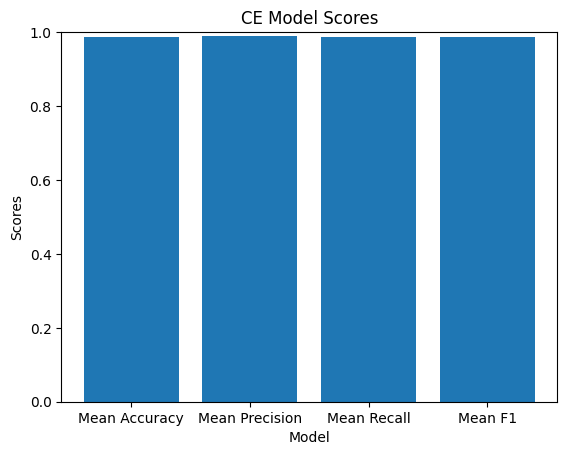

In [ ]:
model = modelCE.get_model()
X_train, _, y_train, _ = modelCE.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('CE', results)

## BG

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/BG_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelBG = MakeModel(df, cols)
modelBG.fit_model()

Epoch 1/80
761/761 - 26s - loss: 0.1181 - accuracy: 0.9747 - val_loss: 0.0831 - val_accuracy: 0.9804 - 26s/epoch - 35ms/step
Epoch 2/80
761/761 - 6s - loss: 0.0833 - accuracy: 0.9803 - val_loss: 0.0815 - val_accuracy: 0.9817 - 6s/epoch - 8ms/step
Epoch 3/80
761/761 - 7s - loss: 0.0819 - accuracy: 0.9805 - val_loss: 0.0798 - val_accuracy: 0.9813 - 7s/epoch - 10ms/step
Epoch 4/80
761/761 - 5s - loss: 0.0817 - accuracy: 0.9808 - val_loss: 0.0806 - val_accuracy: 0.9809 - 5s/epoch - 7ms/step
Epoch 5/80
761/761 - 6s - loss: 0.0813 - accuracy: 0.9808 - val_loss: 0.0798 - val_accuracy: 0.9810 - 6s/epoch - 8ms/step
Epoch 6/80
761/761 - 6s - loss: 0.0808 - accuracy: 0.9810 - val_loss: 0.0794 - val_accuracy: 0.9817 - 6s/epoch - 8ms/step
Epoch 7/80
761/761 - 5s - loss: 0.0804 - accuracy: 0.9810 - val_loss: 0.0820 - val_accuracy: 0.9812 - 5s/epoch - 7ms/step
Epoch 8/80
761/761 - 7s - loss: 0.0805 - accuracy: 0.9810 - val_loss: 0.0801 - val_accuracy: 0.9815 - 7s/epoch - 9ms/step
Epoch 9/80
761/761 -

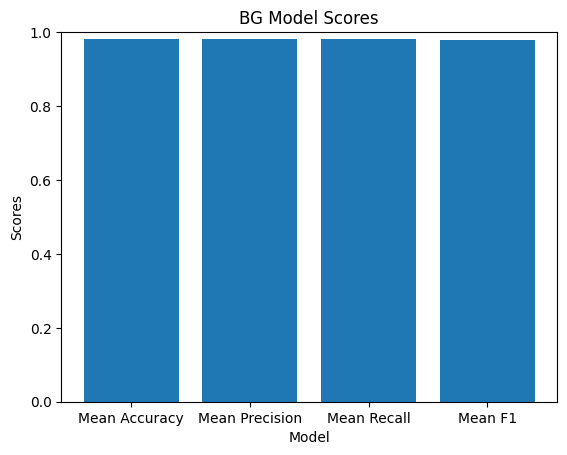

In [ ]:
model = modelBG.get_model()
X_train, _, y_train, _ = modelBG.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('BG', results)

## EG

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/EG_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelEG = MakeModel(df, cols)
modelEG.fit_model()

Epoch 1/80
687/687 - 17s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 17s/epoch - 24ms/step
Epoch 2/80
687/687 - 5s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 5s/epoch - 7ms/step
Epoch 3/80
687/687 - 5s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 5s/epoch - 7ms/step
Epoch 4/80
687/687 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 6s/epoch - 9ms/step
Epoch 5/80
687/687 - 5s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 5s/epoch - 7ms/step
Epoch 6/80
687/687 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 6s/epoch - 8ms/step
Epoch 7/80
687/687 - 6s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 6s/epoch - 8ms/step
Epoch 8/80
687/687 - 5s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - 

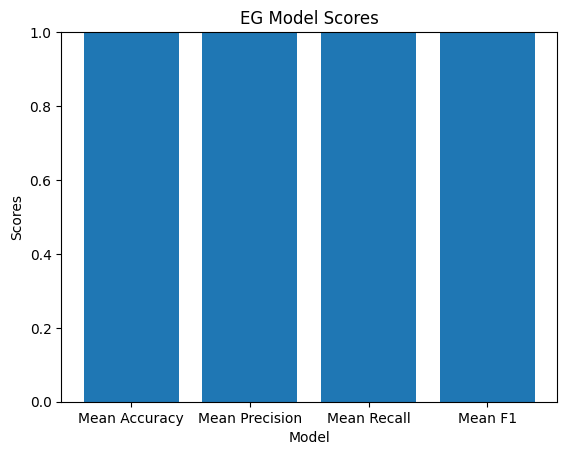

In [ ]:
model = modelEG.get_model()
X_train, _, y_train, _ = modelEG.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('EG', results)

## E4

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/E4_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

modelE4 = MakeModel(df, cols)
modelE4.fit_model()

Epoch 1/80
1859/1859 - 34s - loss: 0.4476 - accuracy: 0.8438 - val_loss: 0.4088 - val_accuracy: 0.8522 - 34s/epoch - 18ms/step
Epoch 2/80
1859/1859 - 16s - loss: 0.3949 - accuracy: 0.8572 - val_loss: 0.3841 - val_accuracy: 0.8606 - 16s/epoch - 9ms/step
Epoch 3/80
1859/1859 - 16s - loss: 0.3818 - accuracy: 0.8605 - val_loss: 0.3813 - val_accuracy: 0.8594 - 16s/epoch - 9ms/step
Epoch 4/80
1859/1859 - 17s - loss: 0.3751 - accuracy: 0.8625 - val_loss: 0.3730 - val_accuracy: 0.8626 - 17s/epoch - 9ms/step
Epoch 5/80
1859/1859 - 17s - loss: 0.3698 - accuracy: 0.8647 - val_loss: 0.3688 - val_accuracy: 0.8631 - 17s/epoch - 9ms/step
Epoch 6/80
1859/1859 - 16s - loss: 0.3657 - accuracy: 0.8657 - val_loss: 0.3711 - val_accuracy: 0.8600 - 16s/epoch - 9ms/step
Epoch 7/80
1859/1859 - 16s - loss: 0.3632 - accuracy: 0.8665 - val_loss: 0.3650 - val_accuracy: 0.8651 - 16s/epoch - 8ms/step
Epoch 8/80
1859/1859 - 17s - loss: 0.3606 - accuracy: 0.8674 - val_loss: 0.3584 - val_accuracy: 0.8676 - 17s/epoch - 

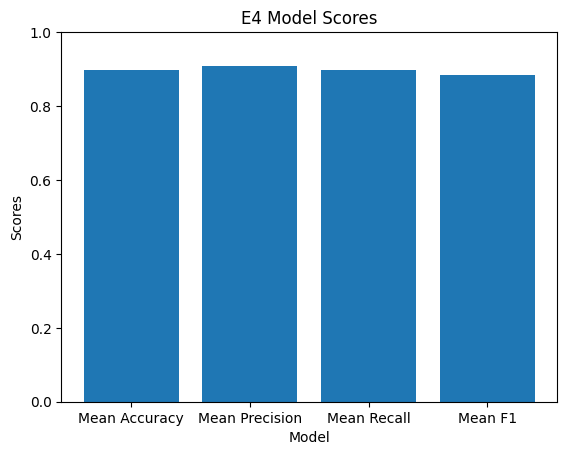

In [ ]:
model = modelE4.get_model()
X_train, _, y_train, _ = modelE4.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('E4', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/8B_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model8B = MakeModel(df, cols)
model8B.fit_model()

Epoch 1/80
529/529 - 13s - loss: 0.5858 - accuracy: 0.7098 - val_loss: 0.5612 - val_accuracy: 0.7109 - 13s/epoch - 25ms/step
Epoch 2/80
529/529 - 5s - loss: 0.5421 - accuracy: 0.7274 - val_loss: 0.5306 - val_accuracy: 0.7278 - 5s/epoch - 9ms/step
Epoch 3/80
529/529 - 4s - loss: 0.5043 - accuracy: 0.7503 - val_loss: 0.4988 - val_accuracy: 0.7454 - 4s/epoch - 8ms/step
Epoch 4/80
529/529 - 5s - loss: 0.4868 - accuracy: 0.7578 - val_loss: 0.4909 - val_accuracy: 0.7548 - 5s/epoch - 10ms/step
Epoch 5/80
529/529 - 5s - loss: 0.4763 - accuracy: 0.7621 - val_loss: 0.4821 - val_accuracy: 0.7572 - 5s/epoch - 9ms/step
Epoch 6/80
529/529 - 4s - loss: 0.4681 - accuracy: 0.7650 - val_loss: 0.4713 - val_accuracy: 0.7621 - 4s/epoch - 8ms/step
Epoch 7/80
529/529 - 5s - loss: 0.4585 - accuracy: 0.7709 - val_loss: 0.4658 - val_accuracy: 0.7650 - 5s/epoch - 9ms/step
Epoch 8/80
529/529 - 5s - loss: 0.4536 - accuracy: 0.7747 - val_loss: 0.4583 - val_accuracy: 0.7685 - 5s/epoch - 10ms/step
Epoch 9/80
529/529 

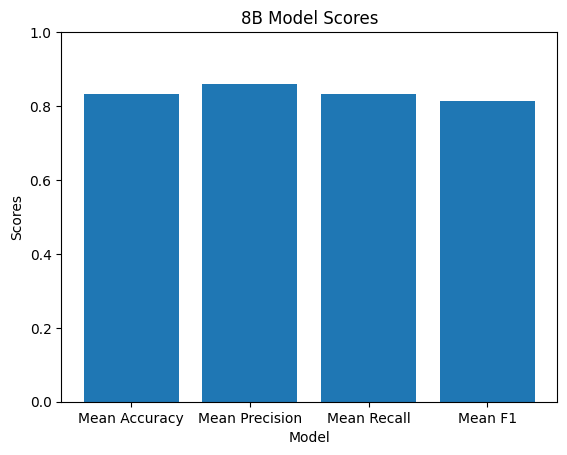

In [ ]:
model = model8B.get_model()
X_train, _, y_train, _ = model8B.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('8B', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/7A_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model7A = MakeModel(df, cols)
model7A.fit_model()

Epoch 1/80
1721/1721 - 32s - loss: 0.6129 - accuracy: 0.7338 - val_loss: 0.5733 - val_accuracy: 0.7502 - 32s/epoch - 18ms/step
Epoch 2/80
1721/1721 - 13s - loss: 0.5670 - accuracy: 0.7519 - val_loss: 0.5529 - val_accuracy: 0.7625 - 13s/epoch - 8ms/step
Epoch 3/80
1721/1721 - 13s - loss: 0.5501 - accuracy: 0.7594 - val_loss: 0.5349 - val_accuracy: 0.7650 - 13s/epoch - 8ms/step
Epoch 4/80
1721/1721 - 12s - loss: 0.5358 - accuracy: 0.7647 - val_loss: 0.5345 - val_accuracy: 0.7668 - 12s/epoch - 7ms/step
Epoch 5/80
1721/1721 - 13s - loss: 0.5247 - accuracy: 0.7694 - val_loss: 0.5268 - val_accuracy: 0.7754 - 13s/epoch - 8ms/step
Epoch 6/80
1721/1721 - 13s - loss: 0.5155 - accuracy: 0.7736 - val_loss: 0.5067 - val_accuracy: 0.7801 - 13s/epoch - 7ms/step
Epoch 7/80
1721/1721 - 14s - loss: 0.5061 - accuracy: 0.7787 - val_loss: 0.5014 - val_accuracy: 0.7836 - 14s/epoch - 8ms/step
Epoch 8/80
1721/1721 - 12s - loss: 0.4959 - accuracy: 0.7837 - val_loss: 0.4874 - val_accuracy: 0.7880 - 12s/epoch - 

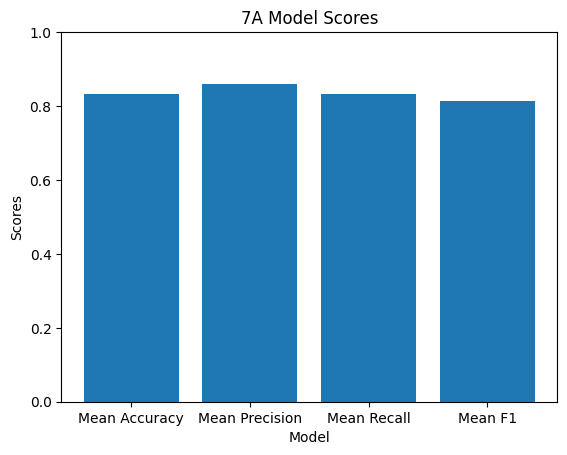

In [ ]:
model = model7A.get_model()
X_train, _, y_train, _ = model7A.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('7A', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/94_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
732/732 - 28s - loss: 0.6689 - accuracy: 0.7283 - val_loss: 0.5881 - val_accuracy: 0.7635 - 28s/epoch - 38ms/step
Epoch 2/80
732/732 - 6s - loss: 0.5675 - accuracy: 0.7708 - val_loss: 0.5535 - val_accuracy: 0.7737 - 6s/epoch - 8ms/step
Epoch 3/80
732/732 - 5s - loss: 0.5508 - accuracy: 0.7752 - val_loss: 0.5452 - val_accuracy: 0.7763 - 5s/epoch - 7ms/step
Epoch 4/80
732/732 - 6s - loss: 0.5397 - accuracy: 0.7795 - val_loss: 0.5373 - val_accuracy: 0.7783 - 6s/epoch - 8ms/step
Epoch 5/80
732/732 - 6s - loss: 0.5309 - accuracy: 0.7832 - val_loss: 0.5243 - val_accuracy: 0.7839 - 6s/epoch - 9ms/step
Epoch 6/80
732/732 - 5s - loss: 0.5253 - accuracy: 0.7858 - val_loss: 0.5183 - val_accuracy: 0.7850 - 5s/epoch - 7ms/step
Epoch 7/80
732/732 - 5s - loss: 0.5206 - accuracy: 0.7881 - val_loss: 0.5158 - val_accuracy: 0.7865 - 5s/epoch - 6ms/step
Epoch 8/80
732/732 - 6s - loss: 0.5161 - accuracy: 0.7897 - val_loss: 0.5118 - val_accuracy: 0.7888 - 6s/epoch - 8ms/step
Epoch 9/80
732/732 - 

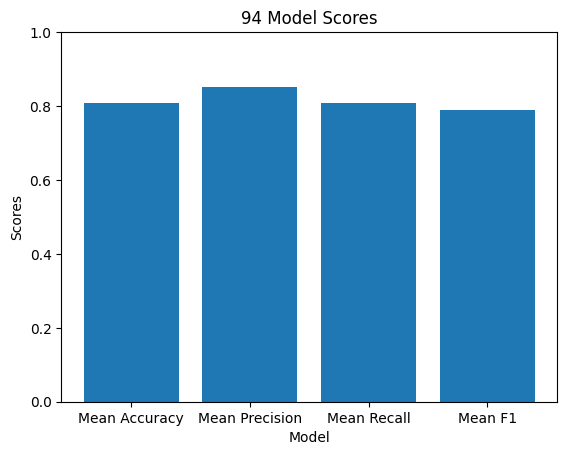

In [ ]:
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('94', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/7E_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])
df['label'] = df['label'].replace(1, 0)
df['label'] = df['label'].replace(2, 1)

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model7E = MakeModel(df, cols)
model7E.fit_model()

Epoch 1/80
317/317 - 12s - loss: 0.5484 - accuracy: 0.6554 - val_loss: 0.4613 - val_accuracy: 0.7135 - 12s/epoch - 37ms/step
Epoch 2/80
317/317 - 2s - loss: 0.4474 - accuracy: 0.7213 - val_loss: 0.4352 - val_accuracy: 0.6919 - 2s/epoch - 7ms/step
Epoch 3/80
317/317 - 2s - loss: 0.4361 - accuracy: 0.7231 - val_loss: 0.4470 - val_accuracy: 0.7200 - 2s/epoch - 7ms/step
Epoch 4/80
317/317 - 3s - loss: 0.4295 - accuracy: 0.7270 - val_loss: 0.4269 - val_accuracy: 0.6943 - 3s/epoch - 8ms/step
Epoch 5/80
317/317 - 4s - loss: 0.4241 - accuracy: 0.7327 - val_loss: 0.4270 - val_accuracy: 0.7336 - 4s/epoch - 11ms/step
Epoch 6/80
317/317 - 2s - loss: 0.4176 - accuracy: 0.7345 - val_loss: 0.4174 - val_accuracy: 0.7447 - 2s/epoch - 7ms/step
Epoch 7/80
317/317 - 2s - loss: 0.4137 - accuracy: 0.7364 - val_loss: 0.4063 - val_accuracy: 0.7466 - 2s/epoch - 7ms/step
Epoch 8/80
317/317 - 2s - loss: 0.4106 - accuracy: 0.7360 - val_loss: 0.4073 - val_accuracy: 0.7461 - 2s/epoch - 7ms/step
Epoch 9/80
317/317 -

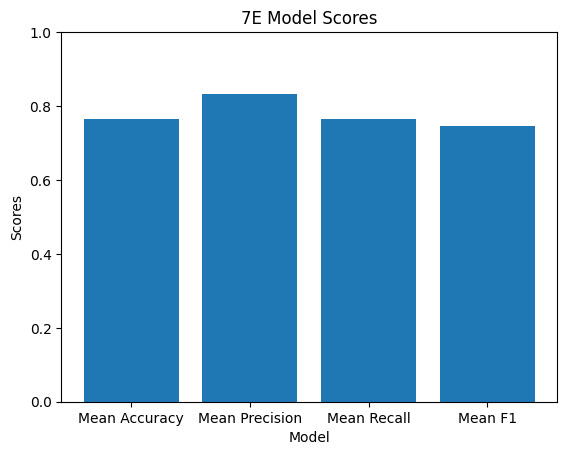

In [ ]:
model = model7E.get_model()
X_train, _, y_train, _ = model7E.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('7E', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/6B_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
1032/1032 - 22s - loss: 0.3083 - accuracy: 0.8757 - val_loss: 0.2809 - val_accuracy: 0.8880 - 22s/epoch - 21ms/step
Epoch 2/80
1032/1032 - 9s - loss: 0.2817 - accuracy: 0.8898 - val_loss: 0.2693 - val_accuracy: 0.9008 - 9s/epoch - 9ms/step
Epoch 3/80
1032/1032 - 11s - loss: 0.2740 - accuracy: 0.8976 - val_loss: 0.2644 - val_accuracy: 0.9016 - 11s/epoch - 11ms/step
Epoch 4/80
1032/1032 - 16s - loss: 0.2680 - accuracy: 0.8999 - val_loss: 0.2591 - val_accuracy: 0.9040 - 16s/epoch - 16ms/step
Epoch 5/80
1032/1032 - 14s - loss: 0.2642 - accuracy: 0.9008 - val_loss: 0.2584 - val_accuracy: 0.9048 - 14s/epoch - 13ms/step
Epoch 6/80
1032/1032 - 9s - loss: 0.2614 - accuracy: 0.9022 - val_loss: 0.2546 - val_accuracy: 0.9056 - 9s/epoch - 9ms/step
Epoch 7/80
1032/1032 - 11s - loss: 0.2582 - accuracy: 0.9033 - val_loss: 0.2509 - val_accuracy: 0.9086 - 11s/epoch - 10ms/step
Epoch 8/80
1032/1032 - 10s - loss: 0.2538 - accuracy: 0.9062 - val_loss: 0.2450 - val_accuracy: 0.9109 - 10s/epoch - 

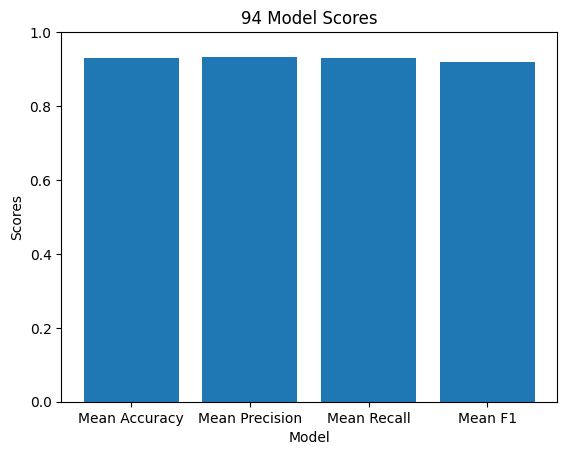

In [ ]:
## Title of this graph is wrong. Should be 6B.
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('6B', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/6D_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
740/740 - 19s - loss: 0.3082 - accuracy: 0.8907 - val_loss: 0.2667 - val_accuracy: 0.9027 - 19s/epoch - 26ms/step
Epoch 2/80
740/740 - 5s - loss: 0.2595 - accuracy: 0.9043 - val_loss: 0.2576 - val_accuracy: 0.9014 - 5s/epoch - 7ms/step
Epoch 3/80
740/740 - 5s - loss: 0.2485 - accuracy: 0.9062 - val_loss: 0.2592 - val_accuracy: 0.9017 - 5s/epoch - 7ms/step
Epoch 4/80
740/740 - 6s - loss: 0.2425 - accuracy: 0.9102 - val_loss: 0.2482 - val_accuracy: 0.9069 - 6s/epoch - 8ms/step
Epoch 5/80
740/740 - 5s - loss: 0.2397 - accuracy: 0.9115 - val_loss: 0.2547 - val_accuracy: 0.9068 - 5s/epoch - 6ms/step
Epoch 6/80
740/740 - 6s - loss: 0.2405 - accuracy: 0.9109 - val_loss: 0.2383 - val_accuracy: 0.9099 - 6s/epoch - 8ms/step
Epoch 7/80
740/740 - 5s - loss: 0.2371 - accuracy: 0.9121 - val_loss: 0.2349 - val_accuracy: 0.9137 - 5s/epoch - 7ms/step
Epoch 8/80
740/740 - 5s - loss: 0.2280 - accuracy: 0.9185 - val_loss: 0.2196 - val_accuracy: 0.9230 - 5s/epoch - 6ms/step
Epoch 9/80
740/740 - 

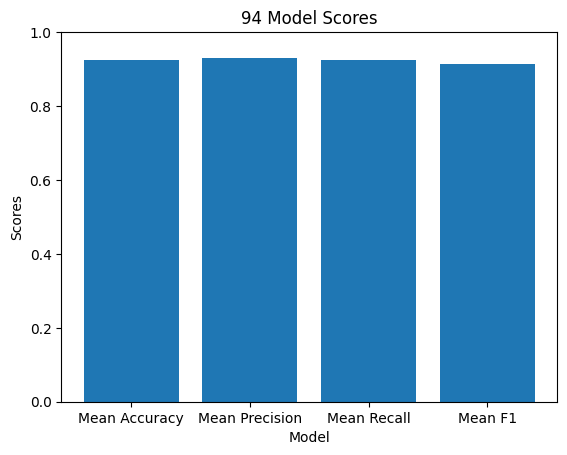

In [ ]:
## Title of this graph is wrong, should be 6D.
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('6D', results)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/5C_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model5C = MakeModel(df, cols)
model5C.fit_model()

Epoch 1/80
1082/1082 - 33s - loss: 0.9188 - accuracy: 0.5011 - val_loss: 0.8543 - val_accuracy: 0.5254 - 33s/epoch - 30ms/step
Epoch 2/80
1082/1082 - 9s - loss: 0.8254 - accuracy: 0.5591 - val_loss: 0.8100 - val_accuracy: 0.5713 - 9s/epoch - 8ms/step
Epoch 3/80
1082/1082 - 10s - loss: 0.7821 - accuracy: 0.5762 - val_loss: 0.7656 - val_accuracy: 0.5858 - 10s/epoch - 10ms/step
Epoch 4/80
1082/1082 - 10s - loss: 0.7366 - accuracy: 0.5960 - val_loss: 0.7228 - val_accuracy: 0.6044 - 10s/epoch - 9ms/step
Epoch 5/80
1082/1082 - 9s - loss: 0.7100 - accuracy: 0.6077 - val_loss: 0.7006 - val_accuracy: 0.6020 - 9s/epoch - 8ms/step
Epoch 6/80
1082/1082 - 10s - loss: 0.6934 - accuracy: 0.6146 - val_loss: 0.6849 - val_accuracy: 0.6221 - 10s/epoch - 9ms/step
Epoch 7/80
1082/1082 - 10s - loss: 0.6798 - accuracy: 0.6197 - val_loss: 0.6868 - val_accuracy: 0.6176 - 10s/epoch - 9ms/step
Epoch 8/80
1082/1082 - 8s - loss: 0.6690 - accuracy: 0.6248 - val_loss: 0.6677 - val_accuracy: 0.6306 - 8s/epoch - 8ms/s

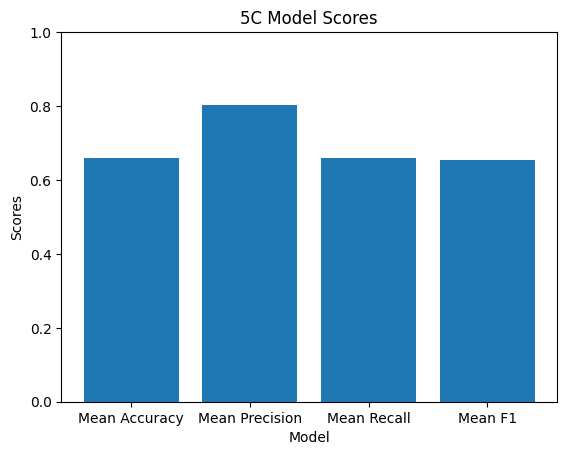

In [ ]:
model = model5C.get_model()
X_train, _, y_train, _ = model5C.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('5C', results)

## 8B

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/8B_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model8B = MakeModel(df, cols)
model8B.fit_model()

Epoch 1/80
529/529 - 13s - loss: 0.5858 - accuracy: 0.7098 - val_loss: 0.5612 - val_accuracy: 0.7109 - 13s/epoch - 25ms/step
Epoch 2/80
529/529 - 5s - loss: 0.5421 - accuracy: 0.7274 - val_loss: 0.5306 - val_accuracy: 0.7278 - 5s/epoch - 9ms/step
Epoch 3/80
529/529 - 4s - loss: 0.5043 - accuracy: 0.7503 - val_loss: 0.4988 - val_accuracy: 0.7454 - 4s/epoch - 8ms/step
Epoch 4/80
529/529 - 5s - loss: 0.4868 - accuracy: 0.7578 - val_loss: 0.4909 - val_accuracy: 0.7548 - 5s/epoch - 10ms/step
Epoch 5/80
529/529 - 5s - loss: 0.4763 - accuracy: 0.7621 - val_loss: 0.4821 - val_accuracy: 0.7572 - 5s/epoch - 9ms/step
Epoch 6/80
529/529 - 4s - loss: 0.4681 - accuracy: 0.7650 - val_loss: 0.4713 - val_accuracy: 0.7621 - 4s/epoch - 8ms/step
Epoch 7/80
529/529 - 5s - loss: 0.4585 - accuracy: 0.7709 - val_loss: 0.4658 - val_accuracy: 0.7650 - 5s/epoch - 9ms/step
Epoch 8/80
529/529 - 5s - loss: 0.4536 - accuracy: 0.7747 - val_loss: 0.4583 - val_accuracy: 0.7685 - 5s/epoch - 10ms/step
Epoch 9/80
529/529 

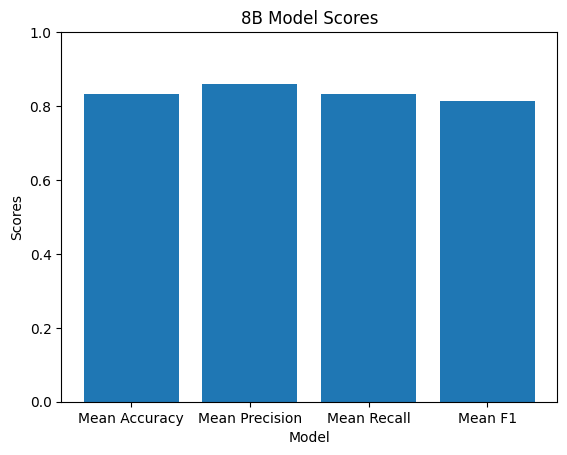

In [ ]:
model = model8B.get_model()
X_train, _, y_train, _ = model8B.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('8B', results)

## 7A

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/7A_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model7A = MakeModel(df, cols)
model7A.fit_model()

Epoch 1/80
1721/1721 - 32s - loss: 0.6129 - accuracy: 0.7338 - val_loss: 0.5733 - val_accuracy: 0.7502 - 32s/epoch - 18ms/step
Epoch 2/80
1721/1721 - 13s - loss: 0.5670 - accuracy: 0.7519 - val_loss: 0.5529 - val_accuracy: 0.7625 - 13s/epoch - 8ms/step
Epoch 3/80
1721/1721 - 13s - loss: 0.5501 - accuracy: 0.7594 - val_loss: 0.5349 - val_accuracy: 0.7650 - 13s/epoch - 8ms/step
Epoch 4/80
1721/1721 - 12s - loss: 0.5358 - accuracy: 0.7647 - val_loss: 0.5345 - val_accuracy: 0.7668 - 12s/epoch - 7ms/step
Epoch 5/80
1721/1721 - 13s - loss: 0.5247 - accuracy: 0.7694 - val_loss: 0.5268 - val_accuracy: 0.7754 - 13s/epoch - 8ms/step
Epoch 6/80
1721/1721 - 13s - loss: 0.5155 - accuracy: 0.7736 - val_loss: 0.5067 - val_accuracy: 0.7801 - 13s/epoch - 7ms/step
Epoch 7/80
1721/1721 - 14s - loss: 0.5061 - accuracy: 0.7787 - val_loss: 0.5014 - val_accuracy: 0.7836 - 14s/epoch - 8ms/step
Epoch 8/80
1721/1721 - 12s - loss: 0.4959 - accuracy: 0.7837 - val_loss: 0.4874 - val_accuracy: 0.7880 - 12s/epoch - 

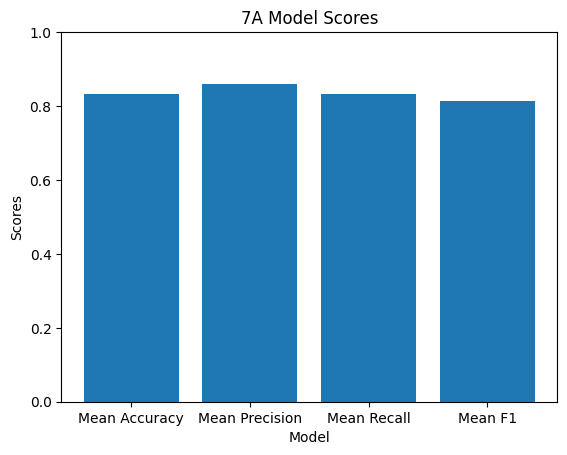

In [ ]:
model = model7A.get_model()
X_train, _, y_train, _ = model7A.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('7A', results)

## 94

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/94_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
732/732 - 28s - loss: 0.6689 - accuracy: 0.7283 - val_loss: 0.5881 - val_accuracy: 0.7635 - 28s/epoch - 38ms/step
Epoch 2/80
732/732 - 6s - loss: 0.5675 - accuracy: 0.7708 - val_loss: 0.5535 - val_accuracy: 0.7737 - 6s/epoch - 8ms/step
Epoch 3/80
732/732 - 5s - loss: 0.5508 - accuracy: 0.7752 - val_loss: 0.5452 - val_accuracy: 0.7763 - 5s/epoch - 7ms/step
Epoch 4/80
732/732 - 6s - loss: 0.5397 - accuracy: 0.7795 - val_loss: 0.5373 - val_accuracy: 0.7783 - 6s/epoch - 8ms/step
Epoch 5/80
732/732 - 6s - loss: 0.5309 - accuracy: 0.7832 - val_loss: 0.5243 - val_accuracy: 0.7839 - 6s/epoch - 9ms/step
Epoch 6/80
732/732 - 5s - loss: 0.5253 - accuracy: 0.7858 - val_loss: 0.5183 - val_accuracy: 0.7850 - 5s/epoch - 7ms/step
Epoch 7/80
732/732 - 5s - loss: 0.5206 - accuracy: 0.7881 - val_loss: 0.5158 - val_accuracy: 0.7865 - 5s/epoch - 6ms/step
Epoch 8/80
732/732 - 6s - loss: 0.5161 - accuracy: 0.7897 - val_loss: 0.5118 - val_accuracy: 0.7888 - 6s/epoch - 8ms/step
Epoch 9/80
732/732 - 

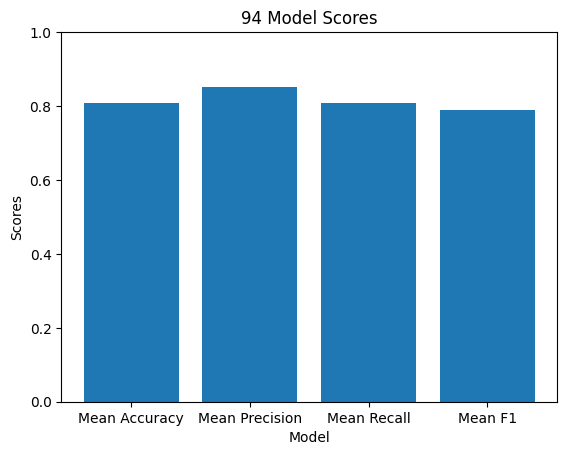

In [ ]:
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('94', results)

## 7E

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/7E_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])
df['label'] = df['label'].replace(1, 0)
df['label'] = df['label'].replace(2, 1)

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model7E = MakeModel(df, cols)
model7E.fit_model()

Epoch 1/80
317/317 - 12s - loss: 0.5484 - accuracy: 0.6554 - val_loss: 0.4613 - val_accuracy: 0.7135 - 12s/epoch - 37ms/step
Epoch 2/80
317/317 - 2s - loss: 0.4474 - accuracy: 0.7213 - val_loss: 0.4352 - val_accuracy: 0.6919 - 2s/epoch - 7ms/step
Epoch 3/80
317/317 - 2s - loss: 0.4361 - accuracy: 0.7231 - val_loss: 0.4470 - val_accuracy: 0.7200 - 2s/epoch - 7ms/step
Epoch 4/80
317/317 - 3s - loss: 0.4295 - accuracy: 0.7270 - val_loss: 0.4269 - val_accuracy: 0.6943 - 3s/epoch - 8ms/step
Epoch 5/80
317/317 - 4s - loss: 0.4241 - accuracy: 0.7327 - val_loss: 0.4270 - val_accuracy: 0.7336 - 4s/epoch - 11ms/step
Epoch 6/80
317/317 - 2s - loss: 0.4176 - accuracy: 0.7345 - val_loss: 0.4174 - val_accuracy: 0.7447 - 2s/epoch - 7ms/step
Epoch 7/80
317/317 - 2s - loss: 0.4137 - accuracy: 0.7364 - val_loss: 0.4063 - val_accuracy: 0.7466 - 2s/epoch - 7ms/step
Epoch 8/80
317/317 - 2s - loss: 0.4106 - accuracy: 0.7360 - val_loss: 0.4073 - val_accuracy: 0.7461 - 2s/epoch - 7ms/step
Epoch 9/80
317/317 -

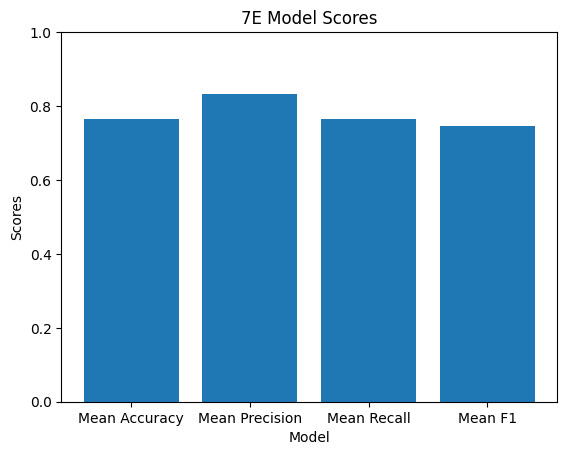

In [ ]:
model = model7E.get_model()
X_train, _, y_train, _ = model7E.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('7E', results)

## 6B

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/6B_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
1032/1032 - 22s - loss: 0.3083 - accuracy: 0.8757 - val_loss: 0.2809 - val_accuracy: 0.8880 - 22s/epoch - 21ms/step
Epoch 2/80
1032/1032 - 9s - loss: 0.2817 - accuracy: 0.8898 - val_loss: 0.2693 - val_accuracy: 0.9008 - 9s/epoch - 9ms/step
Epoch 3/80
1032/1032 - 11s - loss: 0.2740 - accuracy: 0.8976 - val_loss: 0.2644 - val_accuracy: 0.9016 - 11s/epoch - 11ms/step
Epoch 4/80
1032/1032 - 16s - loss: 0.2680 - accuracy: 0.8999 - val_loss: 0.2591 - val_accuracy: 0.9040 - 16s/epoch - 16ms/step
Epoch 5/80
1032/1032 - 14s - loss: 0.2642 - accuracy: 0.9008 - val_loss: 0.2584 - val_accuracy: 0.9048 - 14s/epoch - 13ms/step
Epoch 6/80
1032/1032 - 9s - loss: 0.2614 - accuracy: 0.9022 - val_loss: 0.2546 - val_accuracy: 0.9056 - 9s/epoch - 9ms/step
Epoch 7/80
1032/1032 - 11s - loss: 0.2582 - accuracy: 0.9033 - val_loss: 0.2509 - val_accuracy: 0.9086 - 11s/epoch - 10ms/step
Epoch 8/80
1032/1032 - 10s - loss: 0.2538 - accuracy: 0.9062 - val_loss: 0.2450 - val_accuracy: 0.9109 - 10s/epoch - 

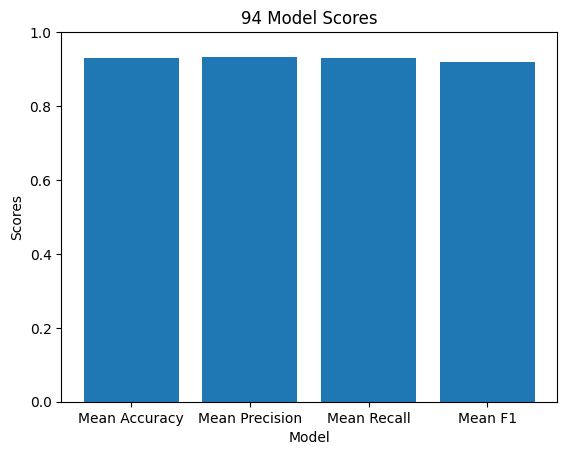

In [ ]:
## Title of this graph is wrong. Should be 6B.
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('6B', results)

## 6D

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/6D_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model94 = MakeModel(df, cols)
model94.fit_model()

Epoch 1/80
740/740 - 19s - loss: 0.3082 - accuracy: 0.8907 - val_loss: 0.2667 - val_accuracy: 0.9027 - 19s/epoch - 26ms/step
Epoch 2/80
740/740 - 5s - loss: 0.2595 - accuracy: 0.9043 - val_loss: 0.2576 - val_accuracy: 0.9014 - 5s/epoch - 7ms/step
Epoch 3/80
740/740 - 5s - loss: 0.2485 - accuracy: 0.9062 - val_loss: 0.2592 - val_accuracy: 0.9017 - 5s/epoch - 7ms/step
Epoch 4/80
740/740 - 6s - loss: 0.2425 - accuracy: 0.9102 - val_loss: 0.2482 - val_accuracy: 0.9069 - 6s/epoch - 8ms/step
Epoch 5/80
740/740 - 5s - loss: 0.2397 - accuracy: 0.9115 - val_loss: 0.2547 - val_accuracy: 0.9068 - 5s/epoch - 6ms/step
Epoch 6/80
740/740 - 6s - loss: 0.2405 - accuracy: 0.9109 - val_loss: 0.2383 - val_accuracy: 0.9099 - 6s/epoch - 8ms/step
Epoch 7/80
740/740 - 5s - loss: 0.2371 - accuracy: 0.9121 - val_loss: 0.2349 - val_accuracy: 0.9137 - 5s/epoch - 7ms/step
Epoch 8/80
740/740 - 5s - loss: 0.2280 - accuracy: 0.9185 - val_loss: 0.2196 - val_accuracy: 0.9230 - 5s/epoch - 6ms/step
Epoch 9/80
740/740 - 

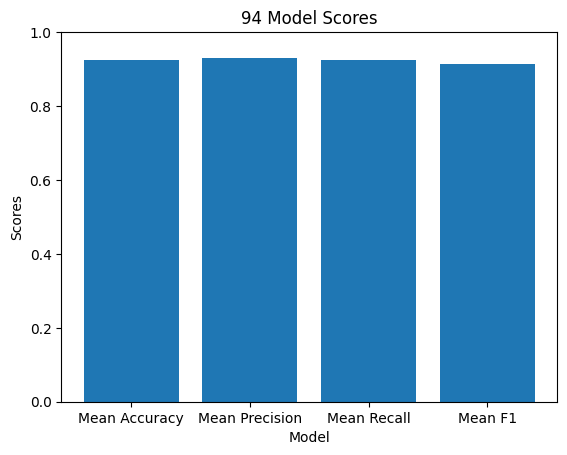

In [ ]:
## Title of this graph is wrong, should be 6D.
model = model94.get_model()
X_train, _, y_train, _ = model94.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('6D', results)

## 5C

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CE888/datasets/5C_fullpreprocessed.csv')
df = df.dropna(axis=0)
df['id'] = df['id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

cols = ['EDA_mean', 'EDA_min', 'EDA_max', 'HR_mean', 'HR_max', 'TEMP_mean',
       'TEMP_max', 'BVP_mean', 'BVP_max', 'lag_EDA_mean', 'lag_EDA_min',
       'lag_EDA_max', 'lag_HR_min', 'lag_HR_max', 'lag_TEMP_mean',
       'lag_TEMP_min', 'lag_TEMP_max']

model5C = MakeModel(df, cols)
model5C.fit_model()

Epoch 1/80
1082/1082 - 33s - loss: 0.9188 - accuracy: 0.5011 - val_loss: 0.8543 - val_accuracy: 0.5254 - 33s/epoch - 30ms/step
Epoch 2/80
1082/1082 - 9s - loss: 0.8254 - accuracy: 0.5591 - val_loss: 0.8100 - val_accuracy: 0.5713 - 9s/epoch - 8ms/step
Epoch 3/80
1082/1082 - 10s - loss: 0.7821 - accuracy: 0.5762 - val_loss: 0.7656 - val_accuracy: 0.5858 - 10s/epoch - 10ms/step
Epoch 4/80
1082/1082 - 10s - loss: 0.7366 - accuracy: 0.5960 - val_loss: 0.7228 - val_accuracy: 0.6044 - 10s/epoch - 9ms/step
Epoch 5/80
1082/1082 - 9s - loss: 0.7100 - accuracy: 0.6077 - val_loss: 0.7006 - val_accuracy: 0.6020 - 9s/epoch - 8ms/step
Epoch 6/80
1082/1082 - 10s - loss: 0.6934 - accuracy: 0.6146 - val_loss: 0.6849 - val_accuracy: 0.6221 - 10s/epoch - 9ms/step
Epoch 7/80
1082/1082 - 10s - loss: 0.6798 - accuracy: 0.6197 - val_loss: 0.6868 - val_accuracy: 0.6176 - 10s/epoch - 9ms/step
Epoch 8/80
1082/1082 - 8s - loss: 0.6690 - accuracy: 0.6248 - val_loss: 0.6677 - val_accuracy: 0.6306 - 8s/epoch - 8ms/s

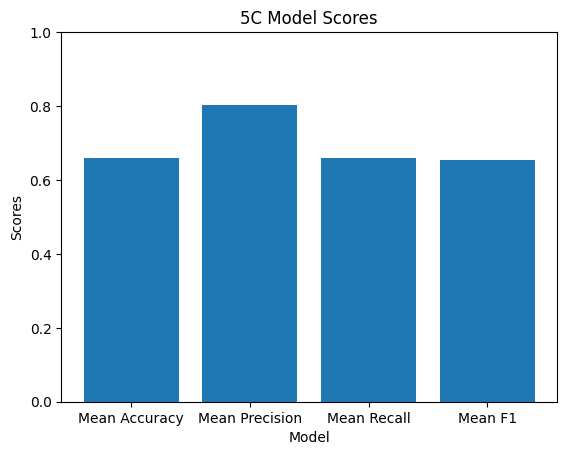

In [ ]:
model = model5C.get_model()
X_train, _, y_train, _ = model5C.get_train_dataset()
results = evaluate(model, X_train, y_train, cv=5)
plot_results('5C', results)